<a href="https://colab.research.google.com/github/marreapato/Forecasting_Paper_XAI/blob/main/stocks_type_lags/DeepModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/modelo_forecasting_xai

!ls

/content/gdrive/MyDrive/modelo_forecasting_xai
final_data.csv	model_bilstm


In [ ]:
data_dir = "/content/gdrive/MyDrive/modelo_forecasting_xai"


In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
# Set seeds for reproducibility
# Set seed for numpy
np.random.seed(42)

# Set seed for Python's random number generator
tf.random.set_seed(42)

# Configure a global random seed in TensorFlow 2.x
tf.compat.v1.random.set_random_seed(42)

# Set seed for any operation level randomness
# Configure TensorFlow session for consistent results
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, GRU, Reshape# captum (biblioteca de interpretação pytorch)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#from tensorflow.compat.v1.keras.backend import get_session

tf.compat.v1.disable_v2_behavior()# Disable TensorFlow v2 behavior for compatibility

# Download data for the stock (I'm using the Bovespa index as an example)
data = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data




/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
Instructions for updating:
non-resource variables are not supported in the long term
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200
2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800
2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000
2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000
2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100
...,...,...,...,...,...,...
2023-10-09,114169.0,115219.0,113448.0,115156.0,115156.0,9474400
2023-10-10,115158.0,116900.0,115158.0,116737.0,116737.0,11621500
2023-10-11,116737.0,117099.0,116231.0,117051.0,117051.0,9949800


In [ ]:
# Download historical data for the BRL to USD exchange rate
exchange_rate_data = yf.download('USDBRL=X', start='2007-01-01', end='2023-10-20')

# Display the first few rows of the downloaded data
exchange_rate_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-01,2.1310,2.1325,2.1310,2.1325,2.1325,0
2007-01-02,2.1335,2.1432,2.1295,2.1310,2.1310,0
2007-01-03,2.1310,2.1351,2.1278,2.1345,2.1345,0
2007-01-04,2.1345,2.1430,2.1345,2.1390,2.1390,0
2007-01-05,2.1390,2.1525,2.1345,2.1470,2.1470,0


In [ ]:
exchange_rate_data.reset_index(inplace=True)
exchange_rate_data = exchange_rate_data[['Date','Close']]
exchange_rate_data = exchange_rate_data.rename(columns={'Close': 'USD'})
exchange_rate_data.head(10)

,Date,USD
0,2007-01-01,2.1325
1,2007-01-02,2.1310
2,2007-01-03,2.1345
3,2007-01-04,2.1390
4,2007-01-05,2.1470
5,2007-01-08,2.1465
6,2007-01-09,2.1490
7,2007-01-10,2.1496
8,2007-01-11,2.1415
9,2007-01-12,2.1370


In [ ]:
# Load structured data from Google Sheets (holidays data)
sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "structured_data"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
feriados = pd.read_csv(url)
feriados = feriados.drop("Unnamed: 4", axis = 1)
feriados

,Date,4_observance,4_optional,4_public
0,2007-01-01,0,0,1
1,2007-01-02,0,0,1
2,2007-02-17,0,1,0
3,2007-02-18,0,1,0
4,2007-02-19,0,1,0
...,...,...,...,...
697,2024-12-25,0,1,0
698,2024-12-25,0,0,1
699,2024-12-26,0,0,1
700,2024-12-31,0,1,0


In [ ]:
data.reset_index(inplace=True)


In [ ]:
feriados['Date']=feriados.Date.astype('datetime64[ns]')

In [ ]:
data=data.merge(feriados, on='Date', how='left')

In [ ]:
# Fill NaN values for holiday columns
data['4_observance'] = data['4_observance'].fillna(0)
data['4_public'] = data['4_public'].fillna(0)
data['4_optional'] = data['4_optional'].fillna(0)

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public
0,2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200,0.0,0.0,1.0
1,2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800,0.0,0.0,0.0
2,2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000,0.0,0.0,0.0
3,2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000,0.0,0.0,0.0
4,2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100,0.0,0.0,0.0


In [ ]:
data=data.merge(exchange_rate_data, on='Date', how='left')# Merge exchange rate data

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,4_observance,4_optional,4_public,USD
0,2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200,0.0,0.0,1.0,2.1310
1,2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800,0.0,0.0,0.0,2.1345
2,2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000,0.0,0.0,0.0,2.1390
3,2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000,0.0,0.0,0.0,2.1470
4,2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100,0.0,0.0,0.0,2.1465
...,...,...,...,...,...,...,...,...,...,...,...
4152,2023-10-09,114169.0,115219.0,113448.0,115156.0,115156.0,9474400,0.0,0.0,0.0,5.1457
4153,2023-10-10,115158.0,116900.0,115158.0,116737.0,116737.0,11621500,0.0,0.0,0.0,5.1352
4154,2023-10-11,116737.0,117099.0,116231.0,117051.0,117051.0,9949800,0.0,0.0,0.0,5.0510
4155,2023-10-13,117050.0,117070.0,115658.0,115754.0,115754.0,10609300,0.0,0.0,1.0,5.0459


In [ ]:
data['variation_low_high'] = ((data['High']-data['Low'])/data['Low'])*100# Calculate variation between high and low prices

In [ ]:
# Drop unnecessary columns
data = data.drop('Adj Close',axis = 1)
data = data.drop('Open',axis = 1)
data = data.drop('High',axis = 1)
data = data.drop('Low',axis = 1)
data = data.drop('Volume',axis = 1)

In [ ]:
# Load SELIC data from Google Sheets (brazilian interest rates)
sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "Selic"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
selic = pd.read_csv(url)
selic = selic.drop("fonte", axis = 1)
selic

,Date,selic
0,24/01/2007,1
1,07/03/2007,1
2,18/04/2007,1
3,06/06/2007,1
4,18/07/2007,1
...,...,...
131,21/06/2023,1
132,02/08/2023,1
133,20/09/2023,1
134,01/11/2023,1


In [ ]:
selic['Date'] = pd.to_datetime(selic['Date'])
selic['Date'].dt.strftime('%Y-%m-%d')

<ipython-input-19-b31719db00c7>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  selic['Date'] = pd.to_datetime(selic['Date'])


0      2007-01-24
1      2007-07-03
2      2007-04-18
3      2007-06-06
4      2007-07-18
          ...    
131    2023-06-21
132    2023-02-08
133    2023-09-20
134    2023-01-11
135    2023-12-13
Name: Date, Length: 136, dtype: object

In [ ]:
data=data.merge(selic, on='Date', how='left')# Merge SELIC data
data['selic'] = data['selic'].fillna(0)
data.head()#SELIC WAS ADDED HERE

,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.050544,0.0
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.472676,0.0
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.877450,0.0
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.556452,0.0
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.855543,0.0


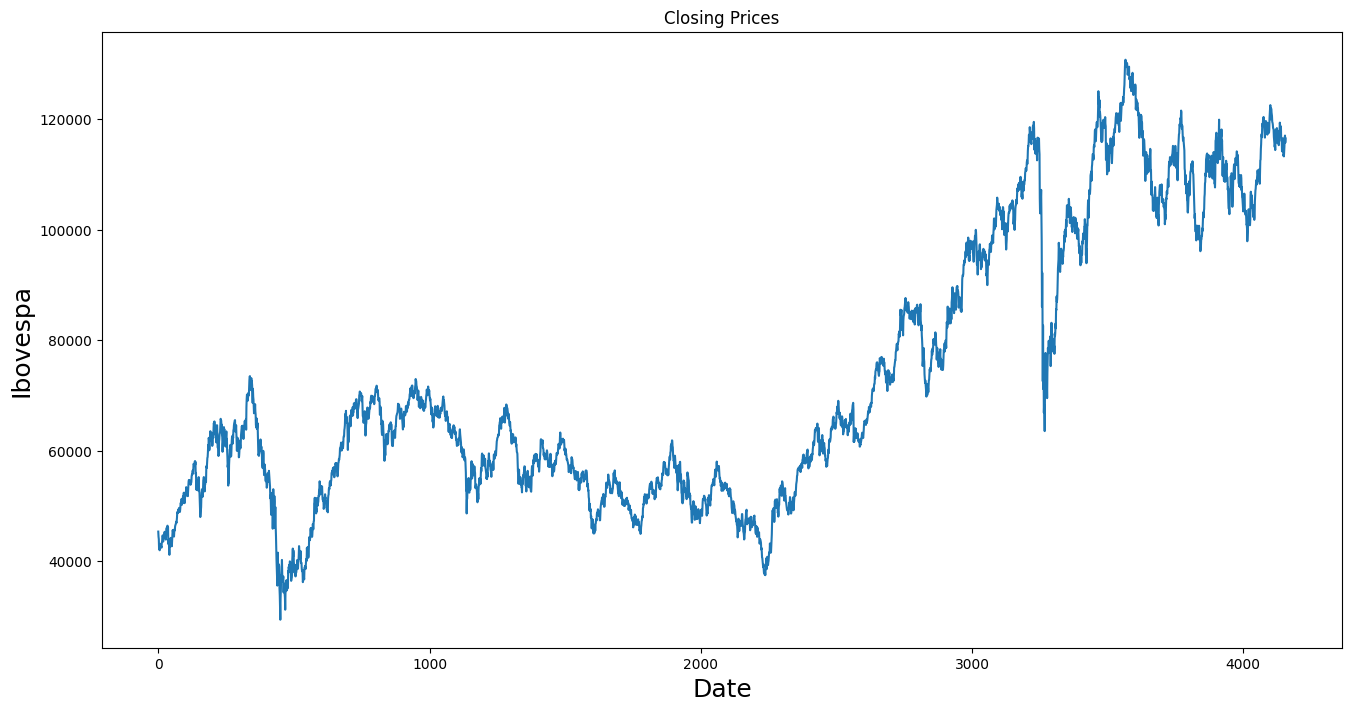

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Closing Prices")
plt.plot(data["Close"])
plt.xlabel("Date",fontsize=18)
plt.ylabel("Ibovespa",fontsize=18)
plt.show()

In [ ]:
look_back=6# Define look back period

In [ ]:
# Calculate size of the training data slice
last_rows=(len(data['Close'])-look_back)-int((len(data['Close'].values.reshape(-1, 1)[:])-look_back)*0.8)
last_rows

831

In [ ]:
size_of_slice=round((len(data['Close'].values.reshape(-1, 1)[:]))*0.8)
size_of_slice=size_of_slice+(len(data)-(size_of_slice+last_rows))
size_of_slice



3326

In [ ]:
data['Close']

0        45383.0
1        44445.0
2        44020.0
3        42245.0
4        42830.0
          ...   
4152    115156.0
4153    116737.0
4154    117051.0
4155    115754.0
4156    116534.0
Name: Close, Length: 4157, dtype: float64

In [ ]:
# Normalize the data
closescaler = MinMaxScaler()

data_train=pd.DataFrame(closescaler.fit_transform(data['Close'].values[0:size_of_slice].reshape(-1, 1)),
                        columns=['Close'],index=data['Close'].index[0:size_of_slice])#use fit only in training that is wrong
data_test=pd.DataFrame(closescaler.transform(data['Close'].values[size_of_slice:size_of_slice+last_rows].reshape(-1, 1)),
                       columns=['Close'],index=data['Close'].index[size_of_slice:size_of_slice+last_rows])#use fit only in training that is wrong

In [ ]:
train_datanscal = data.iloc[0:size_of_slice]
test_datanscal = data.iloc[size_of_slice:size_of_slice+last_rows]

In [ ]:
data.columns

Index(['Date', 'Close', '4_observance', '4_optional', '4_public', 'USD',
       'variation_low_high', 'selic'],
      dtype='object')

In [ ]:
# Normalize the data
scaler = MinMaxScaler()

train_datanscal[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']] = scaler.fit_transform(train_datanscal[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']])
train_datanscal.head()

<ipython-input-29-a429711ad29e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_datanscal[['variation_low_high', 'Close',


,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,0.177017,0.0,0.0,1.0,0.137225,0.073612,0.0
1,2007-01-03,0.166606,0.0,0.0,0.0,0.138029,0.091220,0.0
2,2007-01-04,0.161888,0.0,0.0,0.0,0.139063,0.066392,0.0
3,2007-01-05,0.142186,0.0,0.0,0.0,0.140901,0.178138,0.0
4,2007-01-08,0.148680,0.0,0.0,0.0,0.140786,0.065478,0.0


In [ ]:
test_datanscal[['variation_low_high','Close',
       '4_observance', '4_optional', '4_public','selic','USD']] = scaler.transform(test_datanscal[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']])
test_datanscal.head()

<ipython-input-30-6142978d2355>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_datanscal[['variation_low_high','Close',


,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
3326,2020-06-16,0.711443,0.0,0.0,0.0,0.831554,0.115807,0.0
3327,2020-06-17,0.733819,0.0,0.0,0.0,0.852321,0.125438,1.0
3328,2020-06-18,0.740235,0.0,0.0,0.0,0.848715,0.094322,0.0
3329,2020-06-19,0.745197,0.0,0.0,0.0,0.883015,0.060562,0.0
3330,2020-06-22,0.731477,0.0,0.0,0.0,0.867576,0.076059,0.0


In [ ]:
data_train=train_datanscal.append(test_datanscal)

<ipython-input-31-32928b99b3ff>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_train=train_datanscal.append(test_datanscal)


In [ ]:
data_train.shape

(4157, 8)

In [ ]:
len(data_train)==len(data)

True

In [ ]:
data_train.shape

(4157, 8)

In [ ]:


# Function to create lagged features
def create_lagged_dataframe(data, lags, include_lag0=False,column_name='Close'):
    lagged_data = data.copy()

    if include_lag0:
        lagged_data['lag0'] = lagged_data[column_name]

    for lag in range(1, lags + 1):
        lagged_data[f'lag{lag}{column_name}'] = lagged_data[column_name].shift(lag)

    return lagged_data



# Create lag features for the entire dataset
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data_train, look_back, include_lag0)


In [ ]:
lagged_data = create_lagged_dataframe(lagged_data, look_back, include_lag0,column_name = 'variation_low_high')
lagged_data = create_lagged_dataframe(lagged_data, look_back, include_lag0,column_name = 'USD')

In [ ]:
lagged_data

,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic,lag1Close,lag2Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
0,2007-01-02,0.177017,0.0,0.0,1.0,0.137225,0.073612,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-03,0.166606,0.0,0.0,0.0,0.138029,0.091220,0.0,0.177017,NaN,...,NaN,NaN,NaN,NaN,0.137225,NaN,NaN,NaN,NaN,NaN
2,2007-01-04,0.161888,0.0,0.0,0.0,0.139063,0.066392,0.0,0.166606,0.177017,...,NaN,NaN,NaN,NaN,0.138029,0.137225,NaN,NaN,NaN,NaN
3,2007-01-05,0.142186,0.0,0.0,0.0,0.140901,0.178138,0.0,0.161888,0.166606,...,0.073612,NaN,NaN,NaN,0.139063,0.138029,0.137225,NaN,NaN,NaN
4,2007-01-08,0.148680,0.0,0.0,0.0,0.140786,0.065478,0.0,0.142186,0.161888,...,0.091220,0.073612,NaN,NaN,0.140901,0.139063,0.138029,0.137225,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,2023-10-09,0.951472,0.0,0.0,0.0,0.829830,0.053195,0.0,0.940528,0.930694,...,0.026420,0.058305,0.057538,0.029776,0.834264,0.831874,0.834562,0.810485,0.806189,0.803892
4153,2023-10-10,0.969021,0.0,0.0,0.0,0.827417,0.051177,0.0,0.951472,0.940528,...,0.049294,0.026420,0.058305,0.057538,0.829830,0.834264,0.831874,0.834562,0.810485,0.806189
4154,2023-10-11,0.972506,0.0,0.0,0.0,0.808073,0.019230,0.0,0.969021,0.951472,...,0.096173,0.049294,0.026420,0.058305,0.827417,0.829830,0.834264,0.831874,0.834562,0.810485
4155,2023-10-13,0.958110,0.0,0.0,1.0,0.806901,0.039003,0.0,0.972506,0.969021,...,0.053195,0.096173,0.049294,0.026420,0.808073,0.827417,0.829830,0.834264,0.831874,0.834562


In [ ]:
lagged_data= lagged_data.drop(columns=['USD','variation_low_high'])

In [ ]:
lagged_data = lagged_data.dropna()  # Drop rows with NaN values
# Split data into train and test sets
train_size = int(len(lagged_data) * 0.8)
test_size = len(lagged_data) - train_size
train, test = lagged_data[0:train_size], lagged_data[train_size:len(data)]

In [ ]:
lagged_data.head(-1)

,Date,Close,4_observance,4_optional,4_public,selic,lag1Close,lag2Close,lag3Close,lag4Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
6,2007-01-10,0.143196,0.0,0.0,0.0,0.0,0.139545,0.148680,0.142186,0.161888,...,0.178138,0.066392,0.091220,0.073612,0.141361,0.140786,0.140901,0.139063,0.138029,0.137225
7,2007-01-11,0.146904,0.0,0.0,0.0,0.0,0.143196,0.139545,0.148680,0.142186,...,0.065478,0.178138,0.066392,0.091220,0.141498,0.141361,0.140786,0.140901,0.139063,0.138029
8,2007-01-12,0.151621,0.0,0.0,0.0,0.0,0.146904,0.143196,0.139545,0.148680,...,0.145413,0.065478,0.178138,0.066392,0.139637,0.141498,0.141361,0.140786,0.140901,0.139063
9,2007-01-15,0.149668,0.0,0.0,0.0,0.0,0.151621,0.146904,0.143196,0.139545,...,0.096236,0.145413,0.065478,0.178138,0.138604,0.139637,0.141498,0.141361,0.140786,0.140901
10,2007-01-16,0.146393,0.0,0.0,0.0,0.0,0.149668,0.151621,0.146904,0.143196,...,0.106234,0.096236,0.145413,0.065478,0.138558,0.138604,0.139637,0.141498,0.141361,0.140786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4151,2023-10-06,0.940528,0.0,0.0,0.0,0.0,0.930694,0.934279,0.932192,0.950374,...,0.058305,0.057538,0.029776,0.029606,0.831874,0.834562,0.810485,0.806189,0.803892,0.806051
4152,2023-10-09,0.951472,0.0,0.0,0.0,0.0,0.940528,0.930694,0.934279,0.932192,...,0.026420,0.058305,0.057538,0.029776,0.834264,0.831874,0.834562,0.810485,0.806189,0.803892
4153,2023-10-10,0.969021,0.0,0.0,0.0,0.0,0.951472,0.940528,0.930694,0.934279,...,0.049294,0.026420,0.058305,0.057538,0.829830,0.834264,0.831874,0.834562,0.810485,0.806189
4154,2023-10-11,0.972506,0.0,0.0,0.0,0.0,0.969021,0.951472,0.940528,0.930694,...,0.096173,0.049294,0.026420,0.058305,0.827417,0.829830,0.834264,0.831874,0.834562,0.810485


In [ ]:
# Prepare training and test data
trainX= train.drop(columns=['Close','Date']).values
testX = test.drop(columns=['Close','Date']).values
trainY= train['Close'].values
testY= test['Close'].values

print("TrainX shape:", trainX.shape)
print("TrainY shape:", trainY.shape)
print("TestX shape:", testX.shape)
print("TestY shape:", testY.shape)

TrainX shape: (3237, 22)
TrainY shape: (3237,)
TestX shape: (810, 22)
TestY shape: (810,)


In [ ]:
trainX

array([[0.        , 0.        , 0.        , ..., 0.13906309, 0.13802927,
        0.13722518],
       [0.        , 0.        , 0.        , ..., 0.14090106, 0.13906309,
        0.13802927],
       [0.        , 0.        , 0.        , ..., 0.1407862 , 0.14090106,
        0.13906309],
       ...,
       [0.        , 0.        , 0.        , ..., 0.86789803, 0.87881082,
        0.86900076],
       [0.        , 0.        , 0.        , ..., 0.877754  , 0.86789803,
        0.87881082],
       [0.        , 0.        , 0.        , ..., 0.88315294, 0.877754  ,
        0.86789803]])

In [ ]:
trainX.shape

(3237, 22)

In [ ]:
trainX = np.array(trainX)
testX = np.array(testX)

In [ ]:
np.reshape(trainX, (1,-1)).shape

(1, 71214)

In [ ]:
import tensorflow as tf


# Define the GRU model
def GRU_Model(output_window,look_back):
    model = Sequential([
            tf.keras.layers.Reshape((1, -1)),
            tf.keras.layers.GRU(128, return_sequences=False, input_shape=(trainX.shape[0], trainX.shape[1])),
            tf.keras.layers.Dense(output_window)
        ])
#    model.add(GRU(128, return_sequences=False, input_shape=(1, look_back)))
 #   model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the LSTM model
def LSTM_Model(output_window,look_back):
    model = Sequential([
        tf.keras.layers.Reshape((1, -1)),

          tf.keras.layers.LSTM(128, activation='relu', input_shape=(trainX.shape[0],trainX.shape[1]), return_sequences=True),
        tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(output_window)])
    #model.add(LSTM(128, return_sequences=False, input_shape=(1, look_back)))
    #model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the LSTM model
def biLSTM_Model(output_window,look_back):
    # n_steps = x_train.shape[-2]
    # n_features = x_train.shape[-1]
    model = Sequential([
        tf.keras.layers.Reshape((1, -1)),
        tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(128, activation='relu', input_shape=(trainX.shape[0], trainX.shape[1]), return_sequences=True)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(output_window)]
                       )
    # model.add(tf.keras.layers.Embedding(1, 6, mask_zero=True))


    ##model.add(Bidirectional(LSTM(128, activation='relu', input_shape=(1, look_back), return_sequences=False)))
    #model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
    #model.add(Bidirectional(LSTM(16, activation='relu')))
    # model.add(LSTM(128, return_sequences=False, input_shape=(1, look_back)))
    #model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Define the baseline model
def baseline_model(output_window):
    last_known_value = trainY[-1]
    return np.full((len(testY), output_window), last_known_value)

# Train and evaluate the models
output_window = 1
bilstm_model = biLSTM_Model(output_window,6)
gru_model = GRU_Model(output_window,6)
lstm_model = LSTM_Model(output_window,6)

bilstm_model.fit(trainX, trainY, epochs=30, batch_size=64)
gru_model.fit(trainX, trainY, epochs=30, batch_size=64)
lstm_model.fit(trainX, trainY, epochs=30, batch_size=64)


bilstm_predictions = bilstm_model.predict(testX)
gru_predictions = gru_model.predict(testX)
lstm_predictions = lstm_model.predict(testX)
baseline_predictions = baseline_model(output_window)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 3237 samples
Epoch 1/30
3237/3237 [==============================] - 4s 1ms/sample - loss: 0.0443
Epoch 2/30
3237/3237 [==============================] - 0s 126us/sample - loss: 0.0017
Epoch 3/30
3237/3237 [==============================] - 0s 129us/sample - loss: 4.7018e-04
Epoch 4/30
3237/3237 [==============================] - 0s 136us/sample - loss: 3.9794e-04
Epoch 5/30
3237/3237 [==============================] - 1s 156us/sample - loss: 3.6426e-04
Epoch 6/30
3237/3237 [==============================] - 1s 173us/sample - loss: 3.3831e-04
Epoch 7/30
3237/3237 [==============================] - 0s 135us/sample - loss: 3.2364e-04
Epoch 8/30
3237/3237 [==============================] - 0s 123us/sample - loss: 3.2098e-04
Epoch 9/30
3237/3237 [==============================] - 0s 126us/sample - loss: 3.0173e-04
Epoch 10/30
3237/3237 [==============================] - 0s 132us/sample - loss: 3.0750e-04
Epoch 11/30
3237/3237 [==============================] - 0s 93us/sample - los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:

# Inverse transform the predictions
gru_predictions = closescaler.inverse_transform(gru_predictions.reshape(-1,1))
lstm_predictions = closescaler.inverse_transform(lstm_predictions.reshape(-1,1))
baseline_predictions = closescaler.inverse_transform(baseline_predictions)
# Inverse transform the predictions
bilstm_predictions = closescaler.inverse_transform(bilstm_predictions.reshape(-1,1))


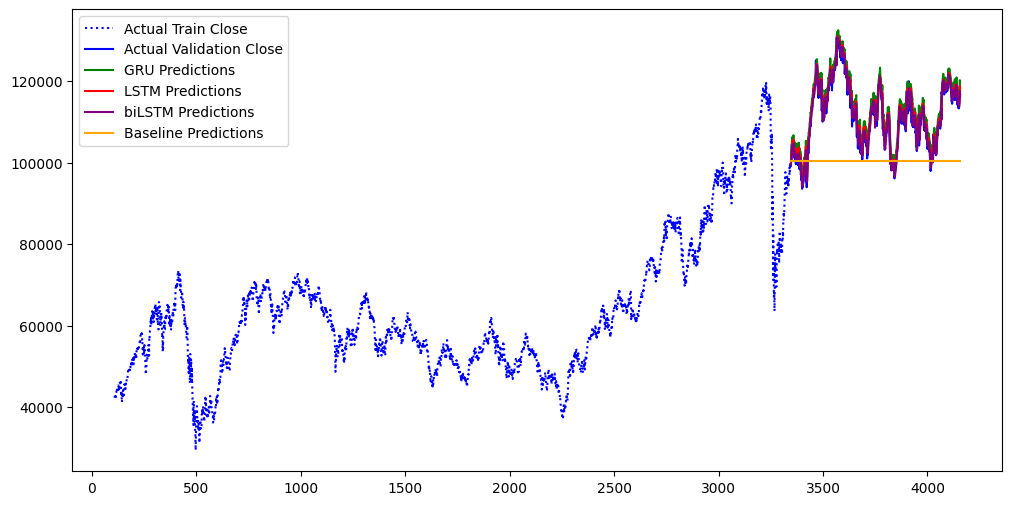

In [ ]:
 #Inverse transform both train and test data
trainY = closescaler.inverse_transform(trainY.reshape(-1, 1))
testY = closescaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = range(len(data) - len(testY) - len(trainY), len(data) - len(testY))
time_index_test = range(len(data) - len(testY), len(data))

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, trainY, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, testY, label='Actual Validation Close', color='blue')
plt.plot(time_index_test, gru_predictions, label='GRU Predictions', color='green')
plt.plot(time_index_test, lstm_predictions, label='LSTM Predictions', color='red')
plt.plot(time_index_test, bilstm_predictions, label='biLSTM Predictions', color='purple')
plt.plot(time_index_test, baseline_predictions, label='Baseline Predictions', color='orange')
plt.legend()
plt.show()

In [ ]:
# Calculate the mean squared error for each model
gru_mse = mean_squared_error(testY, gru_predictions)
lstm_mse = mean_squared_error(testY, lstm_predictions)
bilstm_mse = mean_squared_error(testY, bilstm_predictions)
baseline_mse = mean_squared_error(testY, baseline_predictions)

# Compare the models using Mean Squared Error
print("GRU Model RMSE: ", np.sqrt(gru_mse))
print("LSTM Model RMSE: ", np.sqrt(lstm_mse))
print("biLSTM Model RMSE: ", np.sqrt(bilstm_mse))
print("Baseline Model RMSE: ", np.sqrt(baseline_mse))


GRU Model RMSE:  2722.7717375693433
LSTM Model RMSE:  1856.5015156448792
biLSTM Model RMSE:  1742.4434225430034
Baseline Model RMSE:  13599.373080957143


In [ ]:
# Calculate the Mean Absolute Percentage Error (MAPE) for each model
def calculate_mape(true_values, predicted_values):
    abs_percentage_errors = np.abs((true_values - predicted_values) / true_values)
    mape = np.mean(abs_percentage_errors) * 100  # Convert to percentage
    return mape

gru_mape = calculate_mape(testY, gru_predictions)
lstm_mape = calculate_mape(testY, lstm_predictions)
bilstm_mape = calculate_mape(testY, bilstm_predictions)
baseline_mape = calculate_mape(testY, baseline_predictions)

# Compare the models using Mean Absolute Percentage Error
print("GRU Model MAPE: {:.2f}%".format(gru_mape))
print("LSTM Model MAPE: {:.2f}%".format(lstm_mape))
print("biLSTM Model MAPE: {:.2f}%".format(bilstm_mape))
print("Baseline Model MAPE: {:.2f}%".format(baseline_mape))


GRU Model MAPE: 2.06%
LSTM Model MAPE: 1.33%
biLSTM Model MAPE: 1.24%
Baseline Model MAPE: 9.90%


In [ ]:
def calculate_mae(true_values, predicted_values):
    abs_errors = np.abs(true_values - predicted_values)
    mae = np.mean(abs_errors)
    return mae

gru_mae = calculate_mae(testY, gru_predictions)
lstm_mae = calculate_mae(testY, lstm_predictions)
bilstm_mae = calculate_mae(testY, bilstm_predictions)
baseline_mae = calculate_mae(testY, baseline_predictions)

# Compare the models using Mean Absolute Percentage Error
print("GRU Model MAE: {:.2f}".format(gru_mae))
print("LSTM Model MAE: {:.2f}".format(lstm_mae))
print("biLSTM Model MAE: {:.2f}".format(bilstm_mae))
print("Baseline Model MAE: {:.2f}".format(baseline_mae))

GRU Model MAE: 2266.47
LSTM Model MAE: 1468.30
biLSTM Model MAE: 1375.23
Baseline Model MAE: 11485.75


In [ ]:
# Calculate the MASE for each model
def calculate_mase(model_mae, baseline_mae):
    mase = model_mae / baseline_mae
    return mase

gru_mase = calculate_mase(gru_mae, baseline_mae)
lstm_mase = calculate_mase(lstm_mae, baseline_mae)
bilstm_mase = calculate_mase(bilstm_mae, baseline_mae)

# Compare the models using Mean Absolute Scaled Error
print("GRU Model MASE: {:.2f}".format(gru_mase))
print("LSTM Model MASE: {:.2f}".format(lstm_mase))
print("biLSTM Model MASE: {:.2f}".format(bilstm_mase))

GRU Model MASE: 0.20
LSTM Model MASE: 0.13
biLSTM Model MASE: 0.12


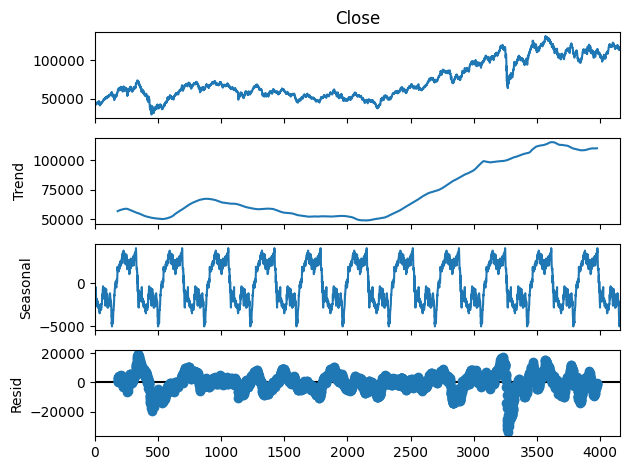

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Close'], model='additive',period=365)
result.plot()
plt.show()

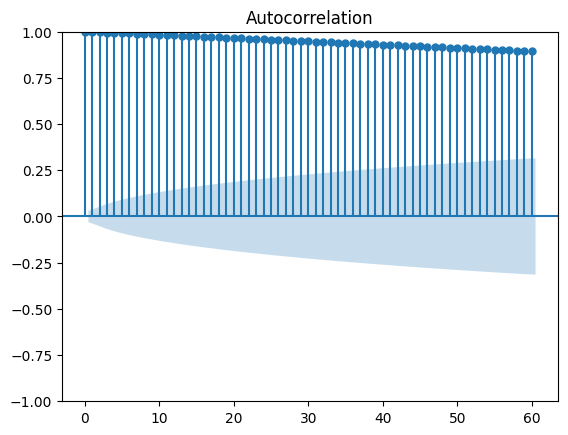

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Close'], lags=60)
plt.show()

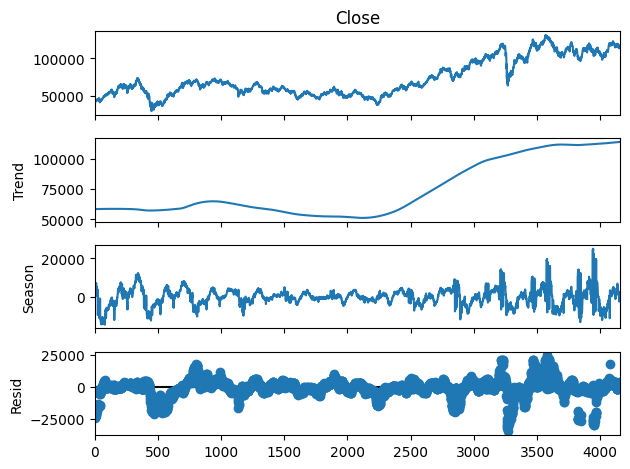

In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(data['Close'], period=365,robust=True)#looking for pattern that repeats annualy
res = stl.fit()
fig = res.plot()

Fourier Transform Interpretations:

 - https://pressbooks.pub/sound/chapter/frequency-domain-graphs-2/
 - https://medium.com/intuition/quantamental-approach-to-stock-trading-using-the-fourier-analysis-58f64792290
 - https://www.marketinout.com/technical_analysis.php?t=Fourier_Transform&id=51

(0.0, 163.95)

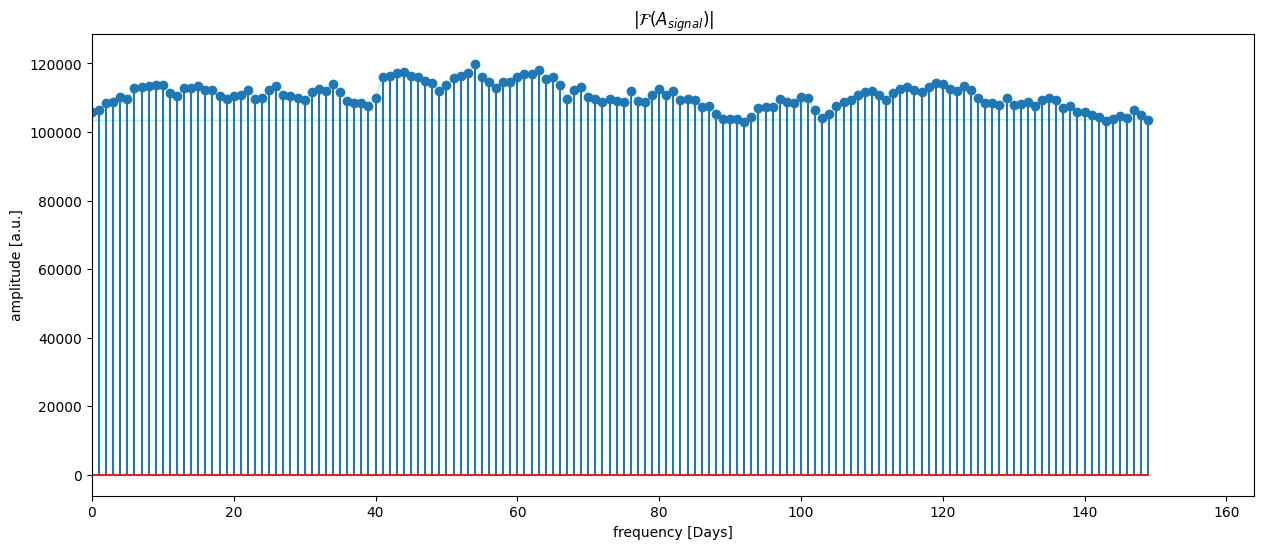

In [ ]:
import scipy.fft
Fs = 300 # Sampling rate
t  = np.arange(0,1,1/Fs)

A_signal_fft = scipy.fft.fft((data[['Close']][len(data[[ 'Close']])-300:]))
frequencies = scipy.fft.fftfreq(np.size(t), 1/Fs)

fig=plt.figure(2, figsize=(15,6))
plt.clf()
plt.plot(frequencies, np.abs(A_signal_fft), lw=1.0, c='paleturquoise')
plt.stem(frequencies, np.abs(A_signal_fft))
plt.xlabel("frequency [Days]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal})|$")

# Set x-axis limit to values greater than or equal to 0
plt.xlim(0, None)

Checking for: feature Importance, that is the reason all data is loaded again, since we are in the process of knowledge mining

In [ ]:
datatree = lagged_data.drop('Date',axis=1)
datatree.head()

,Close,4_observance,4_optional,4_public,selic,lag1Close,lag2Close,lag3Close,lag4Close,lag5Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
6,0.143196,0.0,0.0,0.0,0.0,0.139545,0.148680,0.142186,0.161888,0.166606,...,0.178138,0.066392,0.091220,0.073612,0.141361,0.140786,0.140901,0.139063,0.138029,0.137225
7,0.146904,0.0,0.0,0.0,0.0,0.143196,0.139545,0.148680,0.142186,0.161888,...,0.065478,0.178138,0.066392,0.091220,0.141498,0.141361,0.140786,0.140901,0.139063,0.138029
8,0.151621,0.0,0.0,0.0,0.0,0.146904,0.143196,0.139545,0.148680,0.142186,...,0.145413,0.065478,0.178138,0.066392,0.139637,0.141498,0.141361,0.140786,0.140901,0.139063
9,0.149668,0.0,0.0,0.0,0.0,0.151621,0.146904,0.143196,0.139545,0.148680,...,0.096236,0.145413,0.065478,0.178138,0.138604,0.139637,0.141498,0.141361,0.140786,0.140901
10,0.146393,0.0,0.0,0.0,0.0,0.149668,0.151621,0.146904,0.143196,0.139545,...,0.106234,0.096236,0.145413,0.065478,0.138558,0.138604,0.139637,0.141498,0.141361,0.140786


                   Feature  Importance
4                lag1Close    0.997742
5                lag2Close    0.000489
9                lag6Close    0.000194
8                lag5Close    0.000177
11  lag2variation_low_high    0.000167
12  lag3variation_low_high    0.000164
14  lag5variation_low_high    0.000138
10  lag1variation_low_high    0.000115
15  lag6variation_low_high    0.000111
21                 lag6USD    0.000106


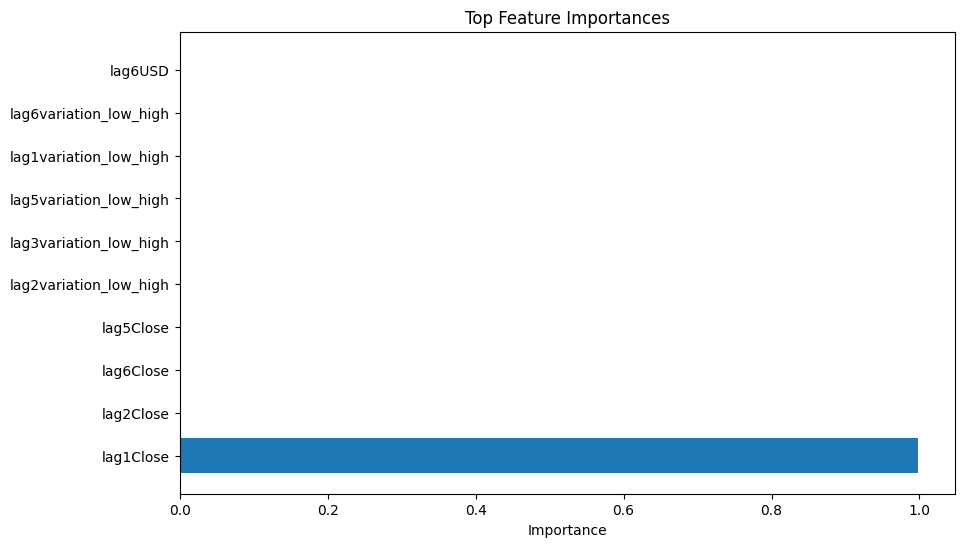

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Split the data into features (X) and the target variable (Y)
X = datatree.drop(columns='Close')
Y = datatree['Close']

# Create and fit the Decision Tree model
regression_tree = DecisionTreeRegressor()
regression_tree.fit(X, Y)

# Calculate feature importances
feature_importances = regression_tree.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features (adjust N as needed)
top_n = 10
print(importance_df.head(top_n))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n], importance_df['Importance'][:top_n])
plt.xlabel('Importance')
plt.title('Top Feature Importances')
plt.show()
#lag1 is way more important than others

In [ ]:
import yfinance as yf
# Download data for the stock (I'm using the Bovespa index as an example)
data3 = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data3 = data3[['Close']]

# Create lag features for the entire dataset
look_back = 6
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data2 = create_lagged_dataframe(data3, look_back, include_lag0)
#lagged_data2 = lagged_data.dropna()  # Drop rows with NaN values
lagged_data2

[*********************100%%**********************]  1 of 1 completed


,Close,lag1Close,lag2Close,lag3Close,lag4Close,lag5Close,lag6Close
Date,,,,,,,
2007-01-02,45383.0,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-03,44445.0,45383.0,NaN,NaN,NaN,NaN,NaN
2007-01-04,44020.0,44445.0,45383.0,NaN,NaN,NaN,NaN
2007-01-05,42245.0,44020.0,44445.0,45383.0,NaN,NaN,NaN
2007-01-08,42830.0,42245.0,44020.0,44445.0,45383.0,NaN,NaN
...,...,...,...,...,...,...,...
2023-10-09,115156.0,114170.0,113284.0,113607.0,113419.0,115057.0,116565.0
2023-10-10,116737.0,115156.0,114170.0,113284.0,113607.0,113419.0,115057.0
2023-10-11,117051.0,116737.0,115156.0,114170.0,113284.0,113607.0,113419.0


In [ ]:
# Save the final dataframe to a CSV file
lagged_data2.to_csv('final_data.csv', index=False)  # Setting index=False to exclude the index column

# Print the first few rows of the final dataframe
print(lagged_data2.head(7))

              Close  lag1Close  lag2Close  lag3Close  lag4Close  lag5Close  \
Date                                                                         
2007-01-02  45383.0        NaN        NaN        NaN        NaN        NaN   
2007-01-03  44445.0    45383.0        NaN        NaN        NaN        NaN   
2007-01-04  44020.0    44445.0    45383.0        NaN        NaN        NaN   
2007-01-05  42245.0    44020.0    44445.0    45383.0        NaN        NaN   
2007-01-08  42830.0    42245.0    44020.0    44445.0    45383.0        NaN   
2007-01-09  42007.0    42830.0    42245.0    44020.0    44445.0    45383.0   
2007-01-10  42336.0    42007.0    42830.0    42245.0    44020.0    44445.0   

            lag6Close  
Date                   
2007-01-02        NaN  
2007-01-03        NaN  
2007-01-04        NaN  
2007-01-05        NaN  
2007-01-08        NaN  
2007-01-09        NaN  
2007-01-10    45383.0  


[*********************100%%**********************]  1 of 1 completed


       Feature  Importance
0    lag1Close    0.997561
1    lag2Close    0.000458
54  lag55Close    0.000113
2    lag3Close    0.000081
26  lag27Close    0.000072
58  lag59Close    0.000066
12  lag13Close    0.000065
16  lag17Close    0.000060
59  lag60Close    0.000058
4    lag5Close    0.000056


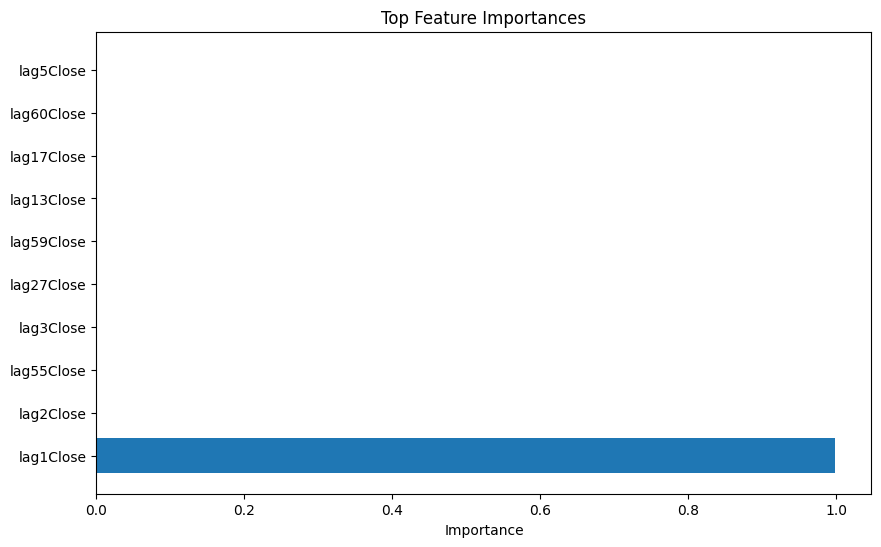

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Download data for the stock (I'm using the Bovespa index as an example)
data3 = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data3 = data3[['Close']]

# Create lag features for the entire dataset
look_back = 60
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data3, look_back, include_lag0)
lagged_data = lagged_data.dropna()  # Drop rows with NaN values
lagged_data

# Split the data into features (X) and the target variable (Y)
X = lagged_data.drop(columns='Close')
Y = lagged_data['Close']

# Create and fit the Decision Tree model
regression_tree = DecisionTreeRegressor()
regression_tree.fit(X, Y)

# Calculate feature importances
feature_importances = regression_tree.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features (adjust N as needed)
top_n = 10
print(importance_df.head(top_n))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:top_n], importance_df['Importance'][:top_n])
plt.xlabel('Importance')
plt.title('Top Feature Importances')
plt.show()
#lag1 is way more important than others

In [ ]:
testX.shape

(810, 22)

# 3 days Window Forecast

In [ ]:
look_back=6

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2 = yf.download('^BVSP', '2007-01-01', '2023-10-21')

# Download historical data for the BRL to USD exchange rate
exchange_rate_data = yf.download('USDBRL=X', start='2007-01-01', end='2023-10-21')

exchange_rate_data.reset_index(inplace=True)
exchange_rate_data = exchange_rate_data[['Date','Close']]
exchange_rate_data = exchange_rate_data.rename(columns={'Close': 'USD'})

sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "structured_data"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
feriados = pd.read_csv(url)
feriados = feriados.drop("Unnamed: 4", axis = 1)
data2.reset_index(inplace=True)
feriados['Date']=feriados.Date.astype('datetime64[ns]')
data2=data2.merge(feriados, on='Date', how='left')
data2['4_observance'] = data2['4_observance'].fillna(0)
data2['4_public'] = data2['4_public'].fillna(0)
data2['4_optional'] = data2['4_optional'].fillna(0)

data2=data2.merge(exchange_rate_data, on='Date', how='left')

data2['variation_low_high'] = ((data2['High']-data2['Low'])/data2['High'])*100

data2 = data2.drop('Adj Close',axis = 1)
data2 = data2.drop('Open',axis = 1)
data2 = data2.drop('High',axis = 1)
data2 = data2.drop('Low',axis = 1)
data2 = data2.drop('Volume',axis = 1)

sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "Selic"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
selic = pd.read_csv(url)
selic = selic.drop("fonte", axis = 1)


selic['Date'] = pd.to_datetime(selic['Date'])
selic['Date'].dt.strftime('%Y-%m-%d')

data2=data2.merge(selic, on='Date', how='left')
data2['selic'] = data2['selic'].fillna(0)
data2#SELIC WAS ADDED HERE

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-64-615e9d954f9f>:40: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  selic['Date'] = pd.to_datetime(selic['Date'])


,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.009342,0.0
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.413010,0.0
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.842851,0.0
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.357887,0.0
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.821740,0.0
...,...,...,...,...,...,...,...,...
4156,2023-10-16,116534.0,0.0,0.0,0.0,5.0482,0.979428,0.0
4157,2023-10-17,115908.0,0.0,0.0,0.0,5.0376,1.157231,0.0
4158,2023-10-18,114060.0,0.0,0.0,0.0,5.0374,1.686697,0.0
4159,2023-10-19,114004.0,0.0,0.0,0.0,5.0561,1.125470,0.0


In [ ]:
data2 = data2.drop('Date',axis = 1)

data2tscale = data2[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']][:4158]

data2testscale = data2[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']][4158:]

In [ ]:
# Normalize the data
train_scaler = MinMaxScaler()

data2tscale[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']] = train_scaler.fit_transform(data2tscale[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']])
data2tscale.head()

,variation_low_high,Close,4_observance,4_optional,4_public,selic,USD
0,0.089632,0.157370,0.0,0.0,1.0,0.0,0.137225
1,0.110614,0.148114,0.0,0.0,0.0,0.0,0.138029
2,0.080978,0.143920,0.0,0.0,0.0,0.0,0.139063
3,0.211708,0.126405,0.0,0.0,0.0,0.0,0.140901
4,0.079880,0.132177,0.0,0.0,0.0,0.0,0.140786


In [ ]:


data2testscale[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']] = train_scaler.transform(data2testscale[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']])
data2testscale.head()

,variation_low_high,Close,4_observance,4_optional,4_public,selic,USD
4158,0.072861,0.835052,0.0,0.0,0.0,0.0,0.804949
4159,0.043689,0.834499,0.0,0.0,0.0,0.0,0.809245
4160,0.056125,0.826122,0.0,0.0,0.0,0.0,0.810807


In [ ]:
datajoined2 = data2tscale.append(data2testscale)

<ipython-input-68-02bc831b04cc>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datajoined2 = data2tscale.append(data2testscale)


In [ ]:
lagged_data2 = create_lagged_dataframe(datajoined2, look_back, include_lag0)
lagged_data2 = create_lagged_dataframe(lagged_data2, look_back, include_lag0,column_name = 'variation_low_high')
lagged_data2 = create_lagged_dataframe(lagged_data2, look_back, include_lag0,column_name = 'USD')
lagged_data2= lagged_data2.drop(columns=['USD','variation_low_high'])
lagged_data2 = lagged_data2.dropna()  # Drop rows with NaN values


In [ ]:
lagged_data2.head()

,Close,4_observance,4_optional,4_public,selic,lag1Close,lag2Close,lag3Close,lag4Close,lag5Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
6,0.127303,0.0,0.0,0.0,0.0,0.124056,0.132177,0.126405,0.143920,0.148114,...,0.211708,0.080978,0.110614,0.089632,0.141361,0.140786,0.140901,0.139063,0.138029,0.137225
7,0.130599,0.0,0.0,0.0,0.0,0.127303,0.124056,0.132177,0.126405,0.143920,...,0.079880,0.211708,0.080978,0.110614,0.141498,0.141361,0.140786,0.140901,0.139063,0.138029
8,0.134792,0.0,0.0,0.0,0.0,0.130599,0.127303,0.124056,0.132177,0.126405,...,0.174122,0.079880,0.211708,0.080978,0.139637,0.141498,0.141361,0.140786,0.140901,0.139063
9,0.133056,0.0,0.0,0.0,0.0,0.134792,0.130599,0.127303,0.124056,0.132177,...,0.116560,0.174122,0.079880,0.211708,0.138604,0.139637,0.141498,0.141361,0.140786,0.140901
10,0.130145,0.0,0.0,0.0,0.0,0.133056,0.134792,0.130599,0.127303,0.124056,...,0.128369,0.116560,0.174122,0.079880,0.138558,0.138604,0.139637,0.141498,0.141361,0.140786


In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
datacheck = yf.download('^BVSP',  '2007-01-01', '2023-10-21')

# Download historical data for the BRL to USD exchange rate
exchange_rate_data = yf.download('USDBRL=X','2007-01-01', '2023-10-21')

exchange_rate_data.reset_index(inplace=True)
exchange_rate_data = exchange_rate_data[['Date','Close']]
exchange_rate_data = exchange_rate_data.rename(columns={'Close': 'USD'})

sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "structured_data"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
feriados = pd.read_csv(url)
feriados = feriados.drop("Unnamed: 4", axis = 1)
datacheck.reset_index(inplace=True)
feriados['Date']=feriados.Date.astype('datetime64[ns]')
datacheck=datacheck.merge(feriados, on='Date', how='left')
datacheck['4_observance'] = datacheck['4_observance'].fillna(0)
datacheck['4_public'] = datacheck['4_public'].fillna(0)
datacheck['4_optional'] = datacheck['4_optional'].fillna(0)

datacheck=datacheck.merge(exchange_rate_data, on='Date', how='left')

datacheck['variation_low_high'] = ((datacheck['High']-datacheck['Low'])/datacheck['High'])*100

datacheck = datacheck.drop('Adj Close',axis = 1)
datacheck = datacheck.drop('Open',axis = 1)
datacheck = datacheck.drop('High',axis = 1)
datacheck = datacheck.drop('Low',axis = 1)
datacheck = datacheck.drop('Volume',axis = 1)

sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "Selic"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
selic = pd.read_csv(url)
selic = selic.drop("fonte", axis = 1)


selic['Date'] = pd.to_datetime(selic['Date'])
selic['Date'].dt.strftime('%Y-%m-%d')

datacheck=datacheck.merge(selic, on='Date', how='left')
datacheck['selic'] = datacheck['selic'].fillna(0)
datacheck.head()#SELIC WAS ADDED HERE

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-71-63122702d47b>:40: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  selic['Date'] = pd.to_datetime(selic['Date'])


,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.009342,0.0
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.413010,0.0
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.842851,0.0
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.357887,0.0
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.821740,0.0


In [ ]:
# Define the baseline model
def baseline_model(output_window,data,column_name='Close'):
    last_known_value = np.array(data[column_name])[-1]
    return np.full((3, output_window), last_known_value)

# Train and evaluate the models
output_window = 1

baseline_predictions = baseline_model(output_window,data)

closedata = datacheck
closegen = MinMaxScaler()
closedata['Close'] = closegen.fit_transform(closedata['Close'].values.reshape(-1, 1))
closedata= closedata[['Close']]

closedata.head()

,Close
0,0.157370
1,0.148114
2,0.143920
3,0.126405
4,0.132177


In [ ]:
lagged_data2.drop(columns=['Close']).values[lagged_data2.drop(columns=['Close']).values.shape[0]-1:lagged_data2.drop(columns=['Close']).values.shape[0]].shape

(1, 22)

In [ ]:
testX = lagged_data2.drop(columns=['Close']).values[lagged_data2.drop(columns=['Close']).values.shape[0]-3:lagged_data2.drop(columns=['Close']).values.shape[0]]
testX

array([[0.        , 0.        , 0.        , 0.        , 0.85328742,
        0.85946458, 0.85176779, 0.86456617, 0.86146772, 0.84586692,
        0.04533982, 0.03609772, 0.04788081, 0.02371758, 0.06264535,
        0.06508371, 0.80499457, 0.80742986, 0.80690139, 0.80807314,
        0.82741743, 0.82982971],
       [0.        , 0.        , 0.        , 0.        , 0.83505195,
        0.85328742, 0.85946458, 0.85176779, 0.86456617, 0.86146772,
        0.07286107, 0.04533982, 0.03609772, 0.04788081, 0.02371758,
        0.06264535, 0.80494856, 0.80499457, 0.80742986, 0.80690139,
        0.80807314, 0.82741743],
       [0.        , 0.        , 0.        , 0.        , 0.83449936,
        0.83505195, 0.85328742, 0.85946458, 0.85176779, 0.86456617,
        0.04368891, 0.07286107, 0.04533982, 0.03609772, 0.04788081,
        0.02371758, 0.80924477, 0.80494856, 0.80499457, 0.80742986,
        0.80690139, 0.80807314]])

In [ ]:
testX[0].reshape(1,-1).shape


(1, 22)

In [ ]:
# List to store multi-step predictions
multi_step_preds = []
multi_step_preds_GRU = []
multi_step_preds_bilstm = []
num_steps=3

for i in range(0,num_steps):

  current_input= testX[i].reshape(1,-1)

  next_step_pred = lstm_model.predict(current_input)
  # Make prediction for the next step
  next_step_pred_GRU = gru_model.predict(current_input)
  # Make prediction for the next step
  next_step_pred_bilstm = bilstm_model.predict(current_input)

  multi_step_preds_GRU.append(next_step_pred_GRU)
    # Append prediction to the list
  multi_step_preds_bilstm.append(next_step_pred_bilstm)

  multi_step_preds.append(next_step_pred)

In [ ]:
multi_step_preds

[array([[0.8651874]], dtype=float32),
 array([[0.8527692]], dtype=float32),
 array([[0.84622717]], dtype=float32)]

In [ ]:
multi_step_preds = closegen.inverse_transform(np.array(multi_step_preds).reshape(-1, 1))
multi_step_preds_bilstm = closegen.inverse_transform(np.array(multi_step_preds_bilstm).reshape(-1, 1))
multi_step_preds_GRU = closegen.inverse_transform(np.array(multi_step_preds_GRU).reshape(-1, 1))

In [ ]:
multi_step_preds_bilstm

array([[116339.445],
       [115156.4  ],
       [114495.47 ]], dtype=float32)

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2test = yf.download('^BVSP', '2023-10-18', '2023-10-21')
data2test= data2test[['Close']]
data2test

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2023-10-18,114060.0
2023-10-19,114004.0
2023-10-20,113155.0


In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2train = yf.download('^BVSP', '2007-01-01', '2023-10-17')

[*********************100%%**********************]  1 of 1 completed


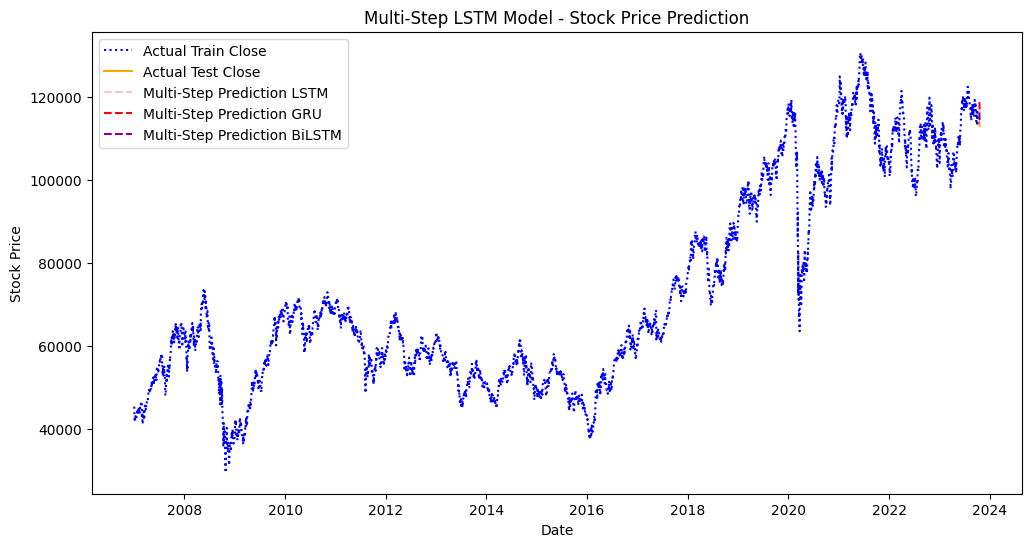

In [ ]:
# Generate future dates for the multi-step prediction
#last_date = lagged_data.index[-1]
#future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_steps)


#Inverse transform both train and test data
#trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
#testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = data2train.index
time_index_test = data2test.index

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, data2train['Close'], label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, data2test['Close'], label='Actual Test Close', color='orange')

# Plot the multi-step predictions
#plt.figure(figsize=(12, 6))
#plt.plot(data.index, data['Close'], label='Historical Data')
plt.plot(time_index_test, multi_step_preds, label='Multi-Step Prediction LSTM', linestyle='dashed',color='pink')
plt.plot(time_index_test, multi_step_preds_GRU, label='Multi-Step Prediction GRU', linestyle='dashed',color='red')
plt.plot(time_index_test, multi_step_preds_bilstm, label='Multi-Step Prediction BiLSTM', linestyle='dashed',color='purple')

plt.title('Multi-Step LSTM Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
test_to_errors=np.array(data2test[['Close']])

baseline_mae = calculate_mae(test_to_errors, baseline_predictions)

lstm_mape15 = calculate_mape(test_to_errors, multi_step_preds)
lstm_mae15 = calculate_mae(test_to_errors, multi_step_preds)
lstm_mase15 = calculate_mase(lstm_mae15,baseline_mae)
lstm_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds))

gru_mape15 = calculate_mape(test_to_errors, multi_step_preds_GRU)
gru_mae15 = calculate_mae(test_to_errors, multi_step_preds_GRU)
gru_mase15 = calculate_mase(gru_mae15,baseline_mae)
gru_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds_GRU))


bilstm_mape15 = calculate_mape(test_to_errors, multi_step_preds_bilstm)
bilstm_mae15 = calculate_mae(test_to_errors, multi_step_preds_bilstm)
bilstm_mase15 = calculate_mase(bilstm_mae15,baseline_mae)
bilstm_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds_bilstm))




print("LSTM Model MAPE: {:.2f}%".format(lstm_mape15))
print("LSTM Model MASE: {:.2f}".format(lstm_mase15))
print("LSTM Model RMSE: {:.2f}".format(lstm_rmse15))

print("GRU Model MAPE: {:.2f}%".format(gru_mape15))
print("GRU Model MASE: {:.2f}".format(gru_mase15))
print("GRU Model RMSE: {:.2f}".format(gru_rmse15))

print("biLSTM Model MAPE: {:.2f}%".format(bilstm_mape15))
print("biLSTM Model MASE: {:.2f}".format(bilstm_mase15))
print("biLSTM Model RMSE: {:.2f}".format(bilstm_rmse15))

print("baseline Model MAE: {:.2f}".format(baseline_mae))


LSTM Model MAPE: 2.03%
LSTM Model MASE: 0.83
LSTM Model RMSE: 2373.89
GRU Model MAPE: 3.70%
GRU Model MASE: 1.50
GRU Model RMSE: 4224.67
biLSTM Model MAPE: 1.40%
biLSTM Model MASE: 0.57
biLSTM Model RMSE: 1665.41
baseline Model MAE: 2794.33


# 7 Days Window Forecast

In [ ]:
look_back=6

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2 = yf.download('^BVSP', '2007-01-01', '2023-10-27')

# Download historical data for the BRL to USD exchange rate
exchange_rate_data = yf.download('USDBRL=X', start='2007-01-01', end='2023-10-27')

exchange_rate_data.reset_index(inplace=True)
exchange_rate_data = exchange_rate_data[['Date','Close']]
exchange_rate_data = exchange_rate_data.rename(columns={'Close': 'USD'})

sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "structured_data"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
feriados = pd.read_csv(url)
feriados = feriados.drop("Unnamed: 4", axis = 1)
data2.reset_index(inplace=True)
feriados['Date']=feriados.Date.astype('datetime64[ns]')
data2=data2.merge(feriados, on='Date', how='left')
data2['4_observance'] = data2['4_observance'].fillna(0)
data2['4_public'] = data2['4_public'].fillna(0)
data2['4_optional'] = data2['4_optional'].fillna(0)

data2=data2.merge(exchange_rate_data, on='Date', how='left')

data2['variation_low_high'] = ((data2['High']-data2['Low'])/data2['High'])*100

data2 = data2.drop('Adj Close',axis = 1)
data2 = data2.drop('Open',axis = 1)
data2 = data2.drop('High',axis = 1)
data2 = data2.drop('Low',axis = 1)
data2 = data2.drop('Volume',axis = 1)

sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "Selic"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
selic = pd.read_csv(url)
selic = selic.drop("fonte", axis = 1)


selic['Date'] = pd.to_datetime(selic['Date'])
selic['Date'].dt.strftime('%Y-%m-%d')

data2=data2.merge(selic, on='Date', how='left')
data2['selic'] = data2['selic'].fillna(0)
data2#SELIC WAS ADDED HERE

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-85-8fc32fca6900>:40: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  selic['Date'] = pd.to_datetime(selic['Date'])


,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.009342,0.0
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.413010,0.0
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.842851,0.0
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.357887,0.0
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.821740,0.0
...,...,...,...,...,...,...,...,...
4160,2023-10-20,113155.0,0.0,0.0,0.0,5.0629,1.364712,0.0
4161,2023-10-23,112785.0,0.0,0.0,0.0,5.0313,1.333568,0.0
4162,2023-10-24,113762.0,0.0,0.0,0.0,5.0123,1.256028,0.0
4163,2023-10-25,112830.0,0.0,0.0,0.0,4.9910,1.433707,0.0


In [ ]:
data2 = data2.drop('Date',axis = 1)

In [ ]:


data2tscale = data2[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']][:4158]

data2testscale = data2[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']][4158:]

In [ ]:
# Normalize the data
train_scaler = MinMaxScaler()

data2tscale[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']] = train_scaler.fit_transform(data2tscale[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']])
data2tscale.head()

,variation_low_high,Close,4_observance,4_optional,4_public,selic,USD
0,0.089632,0.157370,0.0,0.0,1.0,0.0,0.137225
1,0.110614,0.148114,0.0,0.0,0.0,0.0,0.138029
2,0.080978,0.143920,0.0,0.0,0.0,0.0,0.139063
3,0.211708,0.126405,0.0,0.0,0.0,0.0,0.140901
4,0.079880,0.132177,0.0,0.0,0.0,0.0,0.140786


In [ ]:


data2testscale[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']] = train_scaler.transform(data2testscale[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']])
data2testscale.head()

,variation_low_high,Close,4_observance,4_optional,4_public,selic,USD
4158,0.072861,0.835052,0.0,0.0,0.0,0.0,0.804949
4159,0.043689,0.834499,0.0,0.0,0.0,0.0,0.809245
4160,0.056125,0.826122,0.0,0.0,0.0,0.0,0.810807
4161,0.054506,0.822471,0.0,0.0,0.0,0.0,0.803547
4162,0.050475,0.832111,0.0,0.0,0.0,0.0,0.799182


In [ ]:
datajoined2 = data2tscale.append(data2testscale)

<ipython-input-90-02bc831b04cc>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datajoined2 = data2tscale.append(data2testscale)


In [ ]:
lagged_data2 = create_lagged_dataframe(datajoined2, look_back, include_lag0)
lagged_data2 = create_lagged_dataframe(lagged_data2, look_back, include_lag0,column_name = 'variation_low_high')
lagged_data2 = create_lagged_dataframe(lagged_data2, look_back, include_lag0,column_name = 'USD')
lagged_data2= lagged_data2.drop(columns=['USD','variation_low_high'])
lagged_data2 = lagged_data2.dropna()  # Drop rows with NaN values


In [ ]:
lagged_data2.head()

,Close,4_observance,4_optional,4_public,selic,lag1Close,lag2Close,lag3Close,lag4Close,lag5Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
6,0.127303,0.0,0.0,0.0,0.0,0.124056,0.132177,0.126405,0.143920,0.148114,...,0.211708,0.080978,0.110614,0.089632,0.141361,0.140786,0.140901,0.139063,0.138029,0.137225
7,0.130599,0.0,0.0,0.0,0.0,0.127303,0.124056,0.132177,0.126405,0.143920,...,0.079880,0.211708,0.080978,0.110614,0.141498,0.141361,0.140786,0.140901,0.139063,0.138029
8,0.134792,0.0,0.0,0.0,0.0,0.130599,0.127303,0.124056,0.132177,0.126405,...,0.174122,0.079880,0.211708,0.080978,0.139637,0.141498,0.141361,0.140786,0.140901,0.139063
9,0.133056,0.0,0.0,0.0,0.0,0.134792,0.130599,0.127303,0.124056,0.132177,...,0.116560,0.174122,0.079880,0.211708,0.138604,0.139637,0.141498,0.141361,0.140786,0.140901
10,0.130145,0.0,0.0,0.0,0.0,0.133056,0.134792,0.130599,0.127303,0.124056,...,0.128369,0.116560,0.174122,0.079880,0.138558,0.138604,0.139637,0.141498,0.141361,0.140786


In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
datacheck = yf.download('^BVSP',  '2007-01-01', '2023-10-27')

# Download historical data for the BRL to USD exchange rate
exchange_rate_data = yf.download('USDBRL=X','2007-01-01', '2023-10-27')

exchange_rate_data.reset_index(inplace=True)
exchange_rate_data = exchange_rate_data[['Date','Close']]
exchange_rate_data = exchange_rate_data.rename(columns={'Close': 'USD'})

sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "structured_data"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
feriados = pd.read_csv(url)
feriados = feriados.drop("Unnamed: 4", axis = 1)
datacheck.reset_index(inplace=True)
feriados['Date']=feriados.Date.astype('datetime64[ns]')
datacheck=datacheck.merge(feriados, on='Date', how='left')
datacheck['4_observance'] = datacheck['4_observance'].fillna(0)
datacheck['4_public'] = datacheck['4_public'].fillna(0)
datacheck['4_optional'] = datacheck['4_optional'].fillna(0)

datacheck=datacheck.merge(exchange_rate_data, on='Date', how='left')

datacheck['variation_low_high'] = ((datacheck['High']-datacheck['Low'])/datacheck['High'])*100

datacheck = datacheck.drop('Adj Close',axis = 1)
datacheck = datacheck.drop('Open',axis = 1)
datacheck = datacheck.drop('High',axis = 1)
datacheck = datacheck.drop('Low',axis = 1)
datacheck = datacheck.drop('Volume',axis = 1)

sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "Selic"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
selic = pd.read_csv(url)
selic = selic.drop("fonte", axis = 1)


selic['Date'] = pd.to_datetime(selic['Date'])
selic['Date'].dt.strftime('%Y-%m-%d')

datacheck=datacheck.merge(selic, on='Date', how='left')
datacheck['selic'] = datacheck['selic'].fillna(0)
datacheck.head()#SELIC WAS ADDED HERE

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-93-e6523116218f>:40: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  selic['Date'] = pd.to_datetime(selic['Date'])


,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.009342,0.0
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.413010,0.0
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.842851,0.0
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.357887,0.0
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.821740,0.0


In [ ]:
# Define the baseline model
def baseline_model(output_window,data,column_name='Close'):
    last_known_value = np.array(data[column_name])[-1]
    return np.full((7, output_window), last_known_value)

# Train and evaluate the models
output_window = 1

baseline_predictions = baseline_model(output_window,data)

closedata = datacheck
closegen = MinMaxScaler()
closedata['Close'] = closegen.fit_transform(closedata['Close'].values.reshape(-1, 1))
closedata= closedata[['Close']]

closedata.head()

,Close
0,0.157370
1,0.148114
2,0.143920
3,0.126405
4,0.132177


In [ ]:
lagged_data2.drop(columns=['Close']).values[lagged_data2.drop(columns=['Close']).values.shape[0]-7:lagged_data2.drop(columns=['Close']).values.shape[0]].shape

(7, 22)

In [ ]:
testX = lagged_data2.drop(columns=['Close']).values[lagged_data2.drop(columns=['Close']).values.shape[0]-7:lagged_data2.drop(columns=['Close']).values.shape[0]]
testX

array([[0.        , 0.        , 0.        , 0.        , 0.85328742,
        0.85946458, 0.85176779, 0.86456617, 0.86146772, 0.84586692,
        0.04533982, 0.03609772, 0.04788081, 0.02371758, 0.06264535,
        0.06508371, 0.80499457, 0.80742986, 0.80690139, 0.80807314,
        0.82741743, 0.82982971],
       [0.        , 0.        , 0.        , 0.        , 0.83505195,
        0.85328742, 0.85946458, 0.85176779, 0.86456617, 0.86146772,
        0.07286107, 0.04533982, 0.03609772, 0.04788081, 0.02371758,
        0.06264535, 0.80494856, 0.80499457, 0.80742986, 0.80690139,
        0.80807314, 0.82741743],
       [0.        , 0.        , 0.        , 0.        , 0.83449936,
        0.83505195, 0.85328742, 0.85946458, 0.85176779, 0.86456617,
        0.04368891, 0.07286107, 0.04533982, 0.03609772, 0.04788081,
        0.02371758, 0.80924477, 0.80494856, 0.80499457, 0.80742986,
        0.80690139, 0.80807314],
       [0.        , 0.        , 0.        , 0.        , 0.82612171,
        0.8344993

In [ ]:
testX[0].reshape(1,-1).shape


(1, 22)

In [ ]:
# List to store multi-step predictions
multi_step_preds = []
multi_step_preds_GRU = []
multi_step_preds_bilstm = []
num_steps=7

for i in range(0,num_steps):

  current_input= testX[i].reshape(1,-1)

  next_step_pred = lstm_model.predict(current_input)
  # Make prediction for the next step
  next_step_pred_GRU = gru_model.predict(current_input)
  # Make prediction for the next step
  next_step_pred_bilstm = bilstm_model.predict(current_input)

  multi_step_preds_GRU.append(next_step_pred_GRU)
    # Append prediction to the list
  multi_step_preds_bilstm.append(next_step_pred_bilstm)

  multi_step_preds.append(next_step_pred)

In [ ]:
multi_step_preds

[array([[0.8651874]], dtype=float32),
 array([[0.8527692]], dtype=float32),
 array([[0.84622717]], dtype=float32),
 array([[0.8393732]], dtype=float32),
 array([[0.83553416]], dtype=float32),
 array([[0.83747005]], dtype=float32),
 array([[0.8349967]], dtype=float32)]

In [ ]:
multi_step_preds = closegen.inverse_transform(np.array(multi_step_preds).reshape(-1, 1))
multi_step_preds_bilstm = closegen.inverse_transform(np.array(multi_step_preds_bilstm).reshape(-1, 1))
multi_step_preds_GRU = closegen.inverse_transform(np.array(multi_step_preds_GRU).reshape(-1, 1))

In [ ]:
multi_step_preds_bilstm

array([[116339.445],
       [115156.4  ],
       [114495.47 ],
       [113869.07 ],
       [113318.766],
       [113384.375],
       [113075.24 ]], dtype=float32)

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2test = yf.download('^BVSP', '2023-10-18', '2023-10-27')
data2test= data2test[['Close']]
data2test

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2023-10-18,114060.0
2023-10-19,114004.0
2023-10-20,113155.0
2023-10-23,112785.0
2023-10-24,113762.0
2023-10-25,112830.0
2023-10-26,114777.0


In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2train = yf.download('^BVSP', '2007-01-01', '2023-10-17')

[*********************100%%**********************]  1 of 1 completed


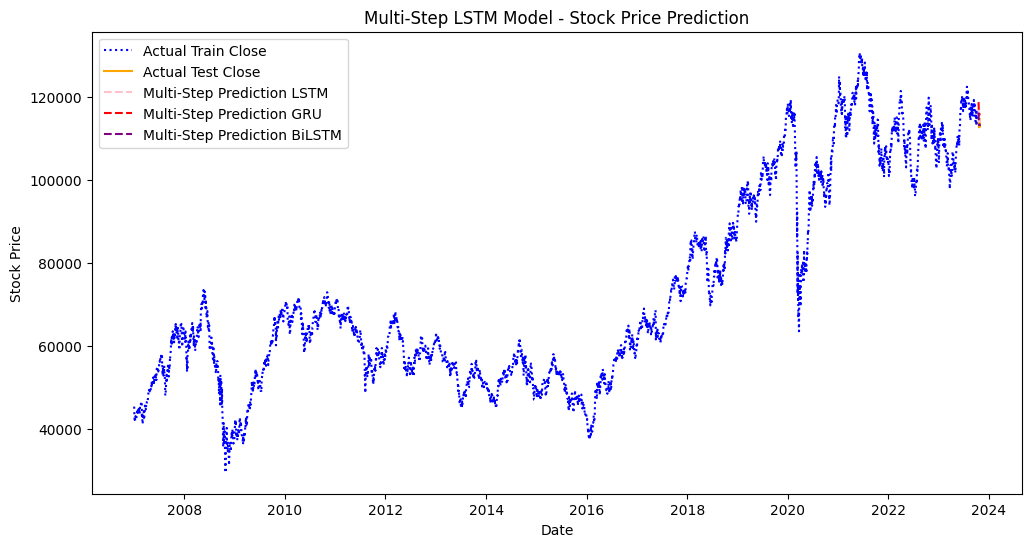

In [ ]:
# Generate future dates for the multi-step prediction
#last_date = lagged_data.index[-1]
#future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_steps)


#Inverse transform both train and test data
#trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
#testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = data2train.index
time_index_test = data2test.index

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, data2train['Close'], label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, data2test['Close'], label='Actual Test Close', color='orange')

# Plot the multi-step predictions
#plt.figure(figsize=(12, 6))
#plt.plot(data.index, data['Close'], label='Historical Data')
plt.plot(time_index_test, multi_step_preds, label='Multi-Step Prediction LSTM', linestyle='dashed',color='pink')
plt.plot(time_index_test, multi_step_preds_GRU, label='Multi-Step Prediction GRU', linestyle='dashed',color='red')
plt.plot(time_index_test, multi_step_preds_bilstm, label='Multi-Step Prediction BiLSTM', linestyle='dashed',color='purple')

plt.title('Multi-Step LSTM Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
test_to_errors=np.array(data2test[['Close']])#real values in the forecast horizon

baseline_mae = calculate_mae(test_to_errors, baseline_predictions)

lstm_mape15 = calculate_mape(test_to_errors, multi_step_preds)
lstm_mae15 = calculate_mae(test_to_errors, multi_step_preds)
lstm_mase15 = calculate_mase(lstm_mae15,baseline_mae)
lstm_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds))

gru_mape15 = calculate_mape(test_to_errors, multi_step_preds_GRU)
gru_mae15 = calculate_mae(test_to_errors, multi_step_preds_GRU)
gru_mase15 = calculate_mase(gru_mae15,baseline_mae)
gru_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds_GRU))


bilstm_mape15 = calculate_mape(test_to_errors, multi_step_preds_bilstm)
bilstm_mae15 = calculate_mae(test_to_errors, multi_step_preds_bilstm)
bilstm_mase15 = calculate_mase(bilstm_mae15,baseline_mae)
bilstm_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds_bilstm))




print("LSTM Model MAPE: {:.2f}%".format(lstm_mape15))
print("LSTM Model MASE: {:.2f}".format(lstm_mase15))
print("LSTM Model RMSE: {:.2f}".format(lstm_rmse15))

print("GRU Model MAPE: {:.2f}%".format(gru_mape15))
print("GRU Model MASE: {:.2f}".format(gru_mase15))
print("GRU Model RMSE: {:.2f}".format(gru_rmse15))

print("biLSTM Model MAPE: {:.2f}%".format(bilstm_mape15))
print("biLSTM Model MASE: {:.2f}".format(bilstm_mase15))
print("biLSTM Model RMSE: {:.2f}".format(bilstm_rmse15))

print("baseline Model MAE: {:.2f}".format(baseline_mae))


LSTM Model MAPE: 1.41%
LSTM Model MASE: 0.55
LSTM Model RMSE: 1799.14
GRU Model MAPE: 2.86%
GRU Model MASE: 1.11
GRU Model RMSE: 3455.65
biLSTM Model MAPE: 1.07%
biLSTM Model MASE: 0.42
biLSTM Model RMSE: 1357.29
baseline Model MAE: 2909.29


# 15 days Window Forecast

In [ ]:
look_back=6

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2 = yf.download('^BVSP', '2007-01-01', '2023-11-09')

# Download historical data for the BRL to USD exchange rate
exchange_rate_data = yf.download('USDBRL=X', start='2007-01-01', end='2023-11-09')

exchange_rate_data.reset_index(inplace=True)
exchange_rate_data = exchange_rate_data[['Date','Close']]
exchange_rate_data = exchange_rate_data.rename(columns={'Close': 'USD'})

sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "structured_data"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
feriados = pd.read_csv(url)
feriados = feriados.drop("Unnamed: 4", axis = 1)
data2.reset_index(inplace=True)
feriados['Date']=feriados.Date.astype('datetime64[ns]')
data2=data2.merge(feriados, on='Date', how='left')
data2['4_observance'] = data2['4_observance'].fillna(0)
data2['4_public'] = data2['4_public'].fillna(0)
data2['4_optional'] = data2['4_optional'].fillna(0)

data2=data2.merge(exchange_rate_data, on='Date', how='left')

data2['variation_low_high'] = ((data2['High']-data2['Low'])/data2['High'])*100

data2 = data2.drop('Adj Close',axis = 1)
data2 = data2.drop('Open',axis = 1)
data2 = data2.drop('High',axis = 1)
data2 = data2.drop('Low',axis = 1)
data2 = data2.drop('Volume',axis = 1)

sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "Selic"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
selic = pd.read_csv(url)
selic = selic.drop("fonte", axis = 1)


selic['Date'] = pd.to_datetime(selic['Date'])
selic['Date'].dt.strftime('%Y-%m-%d')

data2=data2.merge(selic, on='Date', how='left')
data2['selic'] = data2['selic'].fillna(0)
data2#SELIC WAS ADDED HERE

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-107-334b854aaa72>:40: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  selic['Date'] = pd.to_datetime(selic['Date'])


,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.009342,0.0
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.413010,0.0
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.842851,0.0
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.357887,0.0
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.821740,0.0
...,...,...,...,...,...,...,...,...
4168,2023-11-01,115053.0,0.0,0.0,0.0,5.0341,1.971707,0.0
4169,2023-11-03,118160.0,0.0,0.0,1.0,4.9529,2.902905,0.0
4170,2023-11-06,118487.0,0.0,0.0,0.0,4.8992,0.600381,0.0
4171,2023-11-07,119268.0,0.0,0.0,0.0,4.8841,1.297072,0.0


In [ ]:
data2 = data2.drop('Date',axis = 1)

In [ ]:


data2tscale = data2[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']][:4158]

data2testscale = data2[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']][4158:]

In [ ]:
# Normalize the data
train_scaler = MinMaxScaler()

data2tscale[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']] = train_scaler.fit_transform(data2tscale[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']])
data2tscale.head()

,variation_low_high,Close,4_observance,4_optional,4_public,selic,USD
0,0.089632,0.157370,0.0,0.0,1.0,0.0,0.137225
1,0.110614,0.148114,0.0,0.0,0.0,0.0,0.138029
2,0.080978,0.143920,0.0,0.0,0.0,0.0,0.139063
3,0.211708,0.126405,0.0,0.0,0.0,0.0,0.140901
4,0.079880,0.132177,0.0,0.0,0.0,0.0,0.140786


In [ ]:


data2testscale[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']] = train_scaler.transform(data2testscale[['variation_low_high', 'Close',
       '4_observance', '4_optional', '4_public','selic','USD']])
data2testscale.head()

,variation_low_high,Close,4_observance,4_optional,4_public,selic,USD
4158,0.072861,0.835052,0.0,0.0,0.0,0.0,0.804949
4159,0.043689,0.834499,0.0,0.0,0.0,0.0,0.809245
4160,0.056125,0.826122,0.0,0.0,0.0,0.0,0.810807
4161,0.054506,0.822471,0.0,0.0,0.0,0.0,0.803547
4162,0.050475,0.832111,0.0,0.0,0.0,0.0,0.799182


In [ ]:
datajoined2 = data2tscale.append(data2testscale)

<ipython-input-112-02bc831b04cc>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datajoined2 = data2tscale.append(data2testscale)


In [ ]:
lagged_data2 = create_lagged_dataframe(datajoined2, look_back, include_lag0)
lagged_data2 = create_lagged_dataframe(lagged_data2, look_back, include_lag0,column_name = 'variation_low_high')
lagged_data2 = create_lagged_dataframe(lagged_data2, look_back, include_lag0,column_name = 'USD')
lagged_data2= lagged_data2.drop(columns=['USD','variation_low_high'])
lagged_data2 = lagged_data2.dropna()  # Drop rows with NaN values


In [ ]:
lagged_data2.head()

,Close,4_observance,4_optional,4_public,selic,lag1Close,lag2Close,lag3Close,lag4Close,lag5Close,...,lag3variation_low_high,lag4variation_low_high,lag5variation_low_high,lag6variation_low_high,lag1USD,lag2USD,lag3USD,lag4USD,lag5USD,lag6USD
6,0.127303,0.0,0.0,0.0,0.0,0.124056,0.132177,0.126405,0.143920,0.148114,...,0.211708,0.080978,0.110614,0.089632,0.141361,0.140786,0.140901,0.139063,0.138029,0.137225
7,0.130599,0.0,0.0,0.0,0.0,0.127303,0.124056,0.132177,0.126405,0.143920,...,0.079880,0.211708,0.080978,0.110614,0.141498,0.141361,0.140786,0.140901,0.139063,0.138029
8,0.134792,0.0,0.0,0.0,0.0,0.130599,0.127303,0.124056,0.132177,0.126405,...,0.174122,0.079880,0.211708,0.080978,0.139637,0.141498,0.141361,0.140786,0.140901,0.139063
9,0.133056,0.0,0.0,0.0,0.0,0.134792,0.130599,0.127303,0.124056,0.132177,...,0.116560,0.174122,0.079880,0.211708,0.138604,0.139637,0.141498,0.141361,0.140786,0.140901
10,0.130145,0.0,0.0,0.0,0.0,0.133056,0.134792,0.130599,0.127303,0.124056,...,0.128369,0.116560,0.174122,0.079880,0.138558,0.138604,0.139637,0.141498,0.141361,0.140786


In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
datacheck = yf.download('^BVSP',  '2007-01-01', '2023-11-09')

# Download historical data for the BRL to USD exchange rate
exchange_rate_data = yf.download('USDBRL=X','2007-01-01', '2023-11-09')

exchange_rate_data.reset_index(inplace=True)
exchange_rate_data = exchange_rate_data[['Date','Close']]
exchange_rate_data = exchange_rate_data.rename(columns={'Close': 'USD'})

sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "structured_data"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
feriados = pd.read_csv(url)
feriados = feriados.drop("Unnamed: 4", axis = 1)
datacheck.reset_index(inplace=True)
feriados['Date']=feriados.Date.astype('datetime64[ns]')
datacheck=datacheck.merge(feriados, on='Date', how='left')
datacheck['4_observance'] = datacheck['4_observance'].fillna(0)
datacheck['4_public'] = datacheck['4_public'].fillna(0)
datacheck['4_optional'] = datacheck['4_optional'].fillna(0)

datacheck=datacheck.merge(exchange_rate_data, on='Date', how='left')

datacheck['variation_low_high'] = ((datacheck['High']-datacheck['Low'])/datacheck['High'])*100

datacheck = datacheck.drop('Adj Close',axis = 1)
datacheck = datacheck.drop('Open',axis = 1)
datacheck = datacheck.drop('High',axis = 1)
datacheck = datacheck.drop('Low',axis = 1)
datacheck = datacheck.drop('Volume',axis = 1)

sheet_id = "19Qm-gxnILXY8QTBASGfwfxp6NsLMOLuEIVmJbQJF8r4"
sheet_name = "Selic"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
selic = pd.read_csv(url)
selic = selic.drop("fonte", axis = 1)


selic['Date'] = pd.to_datetime(selic['Date'])
selic['Date'].dt.strftime('%Y-%m-%d')

datacheck=datacheck.merge(selic, on='Date', how='left')
datacheck['selic'] = datacheck['selic'].fillna(0)
datacheck.head()#SELIC WAS ADDED HERE

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-115-e724146a09d2>:40: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  selic['Date'] = pd.to_datetime(selic['Date'])


,Date,Close,4_observance,4_optional,4_public,USD,variation_low_high,selic
0,2007-01-02,45383.0,0.0,0.0,1.0,2.1310,2.009342,0.0
1,2007-01-03,44445.0,0.0,0.0,0.0,2.1345,2.413010,0.0
2,2007-01-04,44020.0,0.0,0.0,0.0,2.1390,1.842851,0.0
3,2007-01-05,42245.0,0.0,0.0,0.0,2.1470,4.357887,0.0
4,2007-01-08,42830.0,0.0,0.0,0.0,2.1465,1.821740,0.0


In [ ]:
# Define the baseline model
def baseline_model(output_window,data,column_name='Close'):
    last_known_value = np.array(data[column_name])[-1]
    return np.full((15, output_window), last_known_value)

# Train and evaluate the models
output_window = 1

baseline_predictions = baseline_model(output_window,data)

closedata = datacheck
closegen = MinMaxScaler()
closedata['Close'] = closegen.fit_transform(closedata['Close'].values.reshape(-1, 1))
closedata= closedata[['Close']]

closedata.head()

,Close
0,0.157370
1,0.148114
2,0.143920
3,0.126405
4,0.132177


In [ ]:
lagged_data2.drop(columns=['Close']).values[lagged_data2.drop(columns=['Close']).values.shape[0]-15:lagged_data2.drop(columns=['Close']).values.shape[0]].shape

(15, 22)

In [ ]:
testX = lagged_data2.drop(columns=['Close']).values[lagged_data2.drop(columns=['Close']).values.shape[0]-15:lagged_data2.drop(columns=['Close']).values.shape[0]]
testX

array([[0.        , 0.        , 0.        , 0.        , 0.85328742,
        0.85946458, 0.85176779, 0.86456617, 0.86146772, 0.84586692,
        0.04533982, 0.03609772, 0.04788081, 0.02371758, 0.06264535,
        0.06508371, 0.80499457, 0.80742986, 0.80690139, 0.80807314,
        0.82741743, 0.82982971],
       [0.        , 0.        , 0.        , 0.        , 0.83505195,
        0.85328742, 0.85946458, 0.85176779, 0.86456617, 0.86146772,
        0.07286107, 0.04533982, 0.03609772, 0.04788081, 0.02371758,
        0.06264535, 0.80494856, 0.80499457, 0.80742986, 0.80690139,
        0.80807314, 0.82741743],
       [0.        , 0.        , 0.        , 0.        , 0.83449936,
        0.83505195, 0.85328742, 0.85946458, 0.85176779, 0.86456617,
        0.04368891, 0.07286107, 0.04533982, 0.03609772, 0.04788081,
        0.02371758, 0.80924477, 0.80494856, 0.80499457, 0.80742986,
        0.80690139, 0.80807314],
       [0.        , 0.        , 0.        , 0.        , 0.82612171,
        0.8344993

In [ ]:
testX[0].reshape(1,-1).shape


(1, 22)

In [ ]:
# List to store multi-step predictions
multi_step_preds = []
multi_step_preds_GRU = []
multi_step_preds_bilstm = []
num_steps=15

for i in range(0,num_steps):

  current_input= testX[i].reshape(1,-1)

  next_step_pred = lstm_model.predict(current_input)
  # Make prediction for the next step
  next_step_pred_GRU = gru_model.predict(current_input)
  # Make prediction for the next step
  next_step_pred_bilstm = bilstm_model.predict(current_input)

  multi_step_preds_GRU.append(next_step_pred_GRU)
    # Append prediction to the list
  multi_step_preds_bilstm.append(next_step_pred_bilstm)

  multi_step_preds.append(next_step_pred)

In [ ]:
multi_step_preds

[array([[0.8651874]], dtype=float32),
 array([[0.8527692]], dtype=float32),
 array([[0.84622717]], dtype=float32),
 array([[0.8393732]], dtype=float32),
 array([[0.83553416]], dtype=float32),
 array([[0.83747005]], dtype=float32),
 array([[0.8349967]], dtype=float32),
 array([[0.8388111]], dtype=float32),
 array([[0.8347045]], dtype=float32),
 array([[0.8299024]], dtype=float32),
 array([[0.83091855]], dtype=float32),
 array([[0.85555744]], dtype=float32),
 array([[0.8548307]], dtype=float32),
 array([[0.8706358]], dtype=float32),
 array([[0.88320994]], dtype=float32)]

In [ ]:
multi_step_preds = closegen.inverse_transform(np.array(multi_step_preds).reshape(-1, 1))
multi_step_preds_bilstm = closegen.inverse_transform(np.array(multi_step_preds_bilstm).reshape(-1, 1))
multi_step_preds_GRU = closegen.inverse_transform(np.array(multi_step_preds_GRU).reshape(-1, 1))

In [ ]:
multi_step_preds_bilstm

array([[116339.445],
       [115156.4  ],
       [114495.47 ],
       [113869.07 ],
       [113318.766],
       [113384.375],
       [113075.24 ],
       [113709.21 ],
       [113305.016],
       [112794.195],
       [112833.67 ],
       [114803.03 ],
       [115295.93 ],
       [116584.43 ],
       [118077.33 ]], dtype=float32)

In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2test = yf.download('^BVSP', '2023-10-18', '2023-11-09')
data2test= data2test[['Close']]
data2test

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2023-10-18,114060.0
2023-10-19,114004.0
2023-10-20,113155.0
2023-10-23,112785.0
2023-10-24,113762.0
2023-10-25,112830.0
2023-10-26,114777.0
2023-10-27,113301.0
2023-10-30,112532.0


In [ ]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2train = yf.download('^BVSP', '2007-01-01', '2023-11-09')

[*********************100%%**********************]  1 of 1 completed


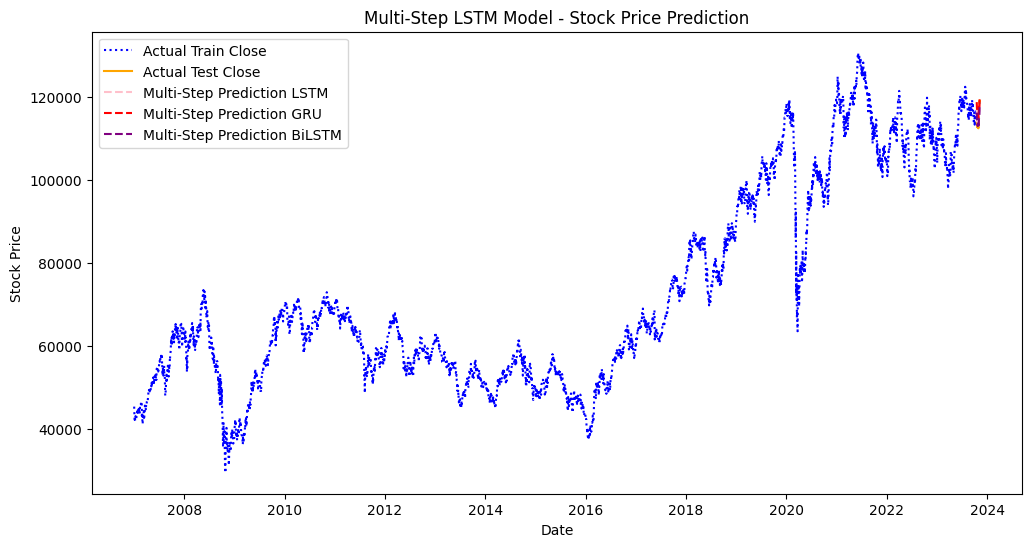

In [ ]:
# Generate future dates for the multi-step prediction
#last_date = lagged_data.index[-1]
#future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_steps)


#Inverse transform both train and test data
#trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
#testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = data2train.index
time_index_test = data2test.index

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, data2train['Close'], label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, data2test['Close'], label='Actual Test Close', color='orange')

# Plot the multi-step predictions
#plt.figure(figsize=(12, 6))
#plt.plot(data.index, data['Close'], label='Historical Data')
plt.plot(time_index_test, multi_step_preds, label='Multi-Step Prediction LSTM', linestyle='dashed',color='pink')
plt.plot(time_index_test, multi_step_preds_GRU, label='Multi-Step Prediction GRU', linestyle='dashed',color='red')
plt.plot(time_index_test, multi_step_preds_bilstm, label='Multi-Step Prediction BiLSTM', linestyle='dashed',color='purple')

plt.title('Multi-Step LSTM Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
test_to_errors=np.array(data2test[['Close']])

baseline_mae = calculate_mae(test_to_errors, baseline_predictions)

lstm_mape15 = calculate_mape(test_to_errors, multi_step_preds)
lstm_mae15 = calculate_mae(test_to_errors, multi_step_preds)
lstm_mase15 = calculate_mase(lstm_mae15,baseline_mae)
lstm_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds))

gru_mape15 = calculate_mape(test_to_errors, multi_step_preds_GRU)
gru_mae15 = calculate_mae(test_to_errors, multi_step_preds_GRU)
gru_mase15 = calculate_mase(gru_mae15,baseline_mae)
gru_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds_GRU))


bilstm_mape15 = calculate_mape(test_to_errors, multi_step_preds_bilstm)
bilstm_mae15 = calculate_mae(test_to_errors, multi_step_preds_bilstm)
bilstm_mase15 = calculate_mase(bilstm_mae15,baseline_mae)
bilstm_rmse15 = np.sqrt(mean_squared_error(test_to_errors, multi_step_preds_bilstm))




print("LSTM Model MAPE: {:.2f}%".format(lstm_mape15))
print("LSTM Model MASE: {:.2f}".format(lstm_mase15))
print("LSTM Model RMSE: {:.2f}".format(lstm_rmse15))

print("GRU Model MAPE: {:.2f}%".format(gru_mape15))
print("GRU Model MASE: {:.2f}".format(gru_mase15))
print("GRU Model RMSE: {:.2f}".format(gru_rmse15))

print("biLSTM Model MAPE: {:.2f}%".format(bilstm_mape15))
print("biLSTM Model MASE: {:.2f}".format(bilstm_mase15))
print("biLSTM Model RMSE: {:.2f}".format(bilstm_rmse15))

print("baseline Model MAE: {:.2f}".format(baseline_mae))


LSTM Model MAPE: 1.27%
LSTM Model MASE: 0.53
LSTM Model RMSE: 1650.93
GRU Model MAPE: 1.95%
GRU Model MASE: 0.81
GRU Model RMSE: 2663.43
biLSTM Model MAPE: 1.30%
biLSTM Model MASE: 0.55
biLSTM Model RMSE: 1796.39
baseline Model MAE: 2756.60


Saving the best model for explainability

In [ ]:
bilstm_model.save("/content/gdrive/MyDrive/modelo_forecasting_xai/model_bilstm")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/modelo_forecasting_xai/model_bilstm')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           multiple                  0         
                                                                 
 bidirectional (Bidirection  multiple                  154624    
 al)                                                             
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  257       
                                                                 
Total params: 154881 (605.00 KB)
Trainable params: 154881 (605.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
